CELL 1 — Install

In [ ]:
!pip -q install -U transformers accelerate datasets peft bitsandbytes sentencepiece evaluate optimum[onnxruntime]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.3/512.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.2/161.2 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.0 MB/s eta 0:00:00


CELL 2 — Imports

In [ ]:
import os, re, json, math, random, time, platform, subprocess
from datetime import datetime

import torch
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    BitsAndBytesConfig, Trainer, TrainingArguments
)
from transformers import TrainerCallback

from peft import LoraConfig, get_peft_model
from optimum.onnxruntime import ORTModelForCausalLM


Multiple distributions found for package optimum. Picked distribution: optimum
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


CELL 3 — Config + Seeds

In [ ]:
import os, re, json, math, random, time, platform, subprocess
from datetime import datetime

import torch
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    BitsAndBytesConfig, Trainer, TrainingArguments
)
from transformers import TrainerCallback

from peft import LoraConfig, get_peft_model
from optimum.onnxruntime import ORTModelForCausalLM


CELL 4 — Logging utilities

In [ ]:
SEED=2025; random.seed(SEED); torch.manual_seed(SEED)

TEACHER_ID="mistralai/Mistral-7B-Instruct-v0.2"
STUDENT_ID="TinyLlama/TinyLlama-1.1B-Chat-v1.0"
DATA_ID="openai/gsm8k"

SAVE_DIR="/content/pocket_teacher"
os.makedirs(SAVE_DIR, exist_ok=True)

RUN_ID = datetime.now().strftime("%Y%m%d_%H%M%S")
EXP_DIR = os.path.join(SAVE_DIR, f"run_{RUN_ID}")
os.makedirs(EXP_DIR, exist_ok=True)

MAX_Q_TOK=384
MAX_A_TOK=192
TOPK=32
TEMP=2.0
ALPHA=0.7

print("EXP_DIR:", EXP_DIR)


EXP_DIR: /content/pocket_teacher/run_20251229_040832


CELL 5 — Load GSM8K + Select subset

In [ ]:
from datasets import load_dataset

ds = load_dataset("openai/gsm8k", "main")

train = ds["train"].shuffle(seed=SEED)
test  = ds["test"]

N_TRAIN = 2500
train = train.select(range(N_TRAIN))

print("train size:", len(train))
print("test size:", len(test))
print("sample keys:", train[0].keys())


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

train size: 2500
test size: 1319
sample keys: dict_keys(['question', 'answer'])


CELL 6 — Teacher load (4-bit)

In [ ]:
bnb = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)

t_tok = AutoTokenizer.from_pretrained(TEACHER_ID, use_fast=True)
t_model = AutoModelForCausalLM.from_pretrained(TEACHER_ID, quantization_config=bnb, device_map="auto")
t_model.eval()

print("Teacher device:", t_model.device)


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Teacher device: cuda:0


CELL 6.5

In [ ]:
if t_tok.pad_token is None:
    t_tok.pad_token = t_tok.eos_token
print("Teacher pad_token:", t_tok.pad_token, "id:", t_tok.pad_token_id)


Teacher pad_token: </s> id: 2


CELL 7 — Prompt helpers + final answer extraction

In [ ]:
import re

def build_prompt_gsm8k(q: str) -> str:
    return (
        "Solve the problem.\n"
        "Return only the final answer in this exact format:\n"
        "#### <number>\n\n"
        f"Problem: {q}\n"
        "Answer:\n"
    )


import re

def extract_final_answer(text: str):
    if not text:
        return None
    s = text.replace(",", "")

    # 1) Strong: look for #### then first number after it
    m = re.search(r"####[^\d\-]*([\-\d]+(?:\.\d+)?)", s)
    if m:
        return m.group(1).strip()

    # 2) "final answer" patterns
    m = re.search(r"(final answer|answer)\s*[:\-]?\s*([\-\d]+(?:\.\d+)?)", s, flags=re.I)
    if m:
        return m.group(2).strip()

    # 3) last number fallback (often works for GSM8K)
    nums = re.findall(r"[\-]?\d+(?:\.\d+)?", s)
    return nums[-1].strip() if nums else None


CELL 8A — Teacher Batch Generate

In [ ]:
import gc, time
import torch

torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

# Default; auto-tune bunu değiştirecek
BATCH_SIZE = 6
SAVE_EVERY_BATCH = 5  # checkpoint sıklığı (batch bazında değil, record bazlı kullanıyoruz)

@torch.no_grad()
def teacher_batch_generate_with_topk(questions):
    prompts = [build_prompt_gsm8k(q) for q in questions]
    enc = t_tok(
      prompts,
      return_tensors="pt",
      padding=True,
      truncation=True,
      max_length=MAX_Q_TOK,
      pad_to_multiple_of=8
    ).to(t_model.device)

    out = t_model.generate(
        **enc,
        max_new_tokens=MAX_A_TOK,
        do_sample=False,
        temperature=1.0,
        use_cache=True,
        return_dict_in_generate=True,
        output_scores=True
    )

    seqs = out.sequences  # (B, L)
    B = seqs.size(0)
    prompt_lens = enc["attention_mask"].sum(dim=1).tolist()

    decoded = [t_tok.decode(seqs[i], skip_special_tokens=True) for i in range(B)]
    finals = [extract_final_answer(txt) for txt in decoded]

    # out.scores: list length = generated_steps, each (B, vocab)
    gen_steps = len(out.scores)

    all_topk_ids = [[] for _ in range(B)]
    all_topk_probs = [[] for _ in range(B)]

    for t in range(gen_steps):
        probs = torch.softmax(out.scores[t] / TEMP, dim=-1)  # (B, vocab)
        p, idx = torch.topk(probs, k=TOPK, dim=-1)           # (B, TOPK)

        idx = idx.detach().cpu().tolist()
        p   = p.detach().cpu().tolist()
        for i in range(B):
            all_topk_ids[i].append(idx[i])
            all_topk_probs[i].append(p[i])

    gen_lens = []
    for i in range(B):
        total_len = int(seqs[i].numel())
        gen_lens.append(max(0, total_len - int(prompt_lens[i])))

    recs = []
    for i in range(B):
        recs.append({
            "question": questions[i],
            "teacher_full_text": decoded[i],
            "teacher_final": finals[i],
            "topk_ids": all_topk_ids[i],
            "topk_probs": all_topk_probs[i],
            "_approx_gen_len": gen_lens[i],
        })
    return recs


/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)


CELL 7.5 — Auto-tune BATCH_SIZE

In [ ]:
import gc, time
import torch

BATCH_CANDIDATES = [10, 8, 6, 4, 2, 1]  # A100’de 8–10 denenebilir

_tune_questions = [train[i]["question"] for i in range(min(32, len(train)))]

def autotune_batch_size():
    global BATCH_SIZE
    best = 1
    for bs in BATCH_CANDIDATES:
        qs = _tune_questions[:bs]
        print(f"Trying BATCH_SIZE={bs} ...")

        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()
            torch.cuda.synchronize()

        try:
            _ = teacher_batch_generate_with_topk(qs)
            peak = (torch.cuda.max_memory_allocated()/1e9) if torch.cuda.is_available() else None
            print(f"  OK   Peak VRAM ~ {peak:.2f} GB" if peak is not None else "  OK ✅")
            best = bs
            break
        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                print("  OOM   Trying smaller batch...")
                continue
            raise e

    BATCH_SIZE = best
    print("Selected BATCH_SIZE =", BATCH_SIZE)

autotune_batch_size()


Trying BATCH_SIZE=10 ...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


  OK   Peak VRAM ~ 5.32 GB
Selected BATCH_SIZE = 10


TÜM HELPER FONKSİYONLARI

In [ ]:
import json, os

def save_json(path, obj):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

def append_jsonl(path, obj):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "a", encoding="utf-8") as f:
        f.write(json.dumps(obj, ensure_ascii=False) + "\n")

def read_jsonl(path):
    rows = []
    if not os.path.exists(path):
        return rows
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                rows.append(json.loads(line))
            except json.JSONDecodeError:
                continue
    return rows


CELL 8B — Distill Generation (Checkpoint + Resume + Verify + Dedup + OOM Auto-Downscale)

In [ ]:
assert "append_jsonl" in globals(), "append_jsonl is not defined. Run helper cell."
assert "save_json" in globals(), "save_json is not defined. Run helper cell."
assert "teacher_batch_generate_with_topk" in globals(), "teacher_batch_generate_with_topk missing."

import os, json, time, hashlib, gc
import torch

# =========================================================
# SPEED + QUALITY PRESET (fast & effective)
# =========================================================
# En çok hız kazandıranlar: TOPK ↓, MAX_A_TOK ↓, batch autotune ↑
# (Kalite çok düşmeden hız artar.)
if "TOPK" in globals():      TOPK = 16     # 32 -> 16 (hız + VRAM)
if "MAX_A_TOK" in globals(): MAX_A_TOK = 128  # 192 -> 128 (hız + VRAM)
if "TEMPERATURE" in globals(): TEMPERATURE = 0.7
if "ALPHA" in globals(): ALPHA = 0.9

# Başlangıç batch (VRAM'e göre otomatik küçültecek)
# 2B/4bit Gemma gibi modellerde 8-16 genelde iyi başlar (4050 için çoğu zaman 8-12).
if "BATCH_SIZE" not in globals():
    BATCH_SIZE = 12
else:
    BATCH_SIZE = int(BATCH_SIZE)

SAVE_EVERY_BATCH = globals().get("SAVE_EVERY_BATCH", 10)  # aynı kalsın
VERIFY_EVERY_N_BATCH = 0  # 0 = kapalı (en hızlı). İstersen 20 yapıp arada bir doğrularsın.

# CUDA perf knobs
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    torch.backends.cudnn.benchmark = True

# autocast dtype seç (bf16 varsa bf16 daha stabil olabilir)
def _autocast_dtype():
    if not torch.cuda.is_available():
        return None
    # bf16 desteği varsa bf16; yoksa fp16
    if torch.cuda.is_bf16_supported():
        return torch.bfloat16
    return torch.float16

AUTOCAST_DTYPE = _autocast_dtype()

# =========================================================
# PATHS
# =========================================================
DISTILL_PATH  = os.path.join(EXP_DIR, "distill_gsm8k.jsonl")
PROGRESS_PATH = os.path.join(EXP_DIR, "progress.jsonl")
STATE_PATH    = os.path.join(EXP_DIR, "state_teacher_gen.json")


# =========================================================
# HELPERS
# =========================================================
def qhash(q: str) -> str:
    return hashlib.md5(q.strip().encode("utf-8")).hexdigest()

def load_existing_hashes(path, limit=None):
    hs = set()
    if not os.path.exists(path):
        return hs
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            try:
                obj = json.loads(line)
                if "question" in obj:
                    hs.add(obj.get("_qhash", qhash(obj["question"])))
            except Exception:
                pass
            if limit is not None and (i+1) >= limit:
                break
    return hs

def count_jsonl_lines_once(path):
    """Sadece resume için 1 kere say."""
    if not os.path.exists(path):
        return 0
    n = 0
    with open(path, "r", encoding="utf-8") as f:
        for _ in f:
            n += 1
    return n


# =========================================================
# OOM-safe generate: küçült -> dene, başarılı olunca yavaş yavaş büyüt
# =========================================================
def safe_teacher_batch_generate(questions, max_retries=6, grow_back=True):
    """
    OOM olursa batch'i yarıya indirip yeniden dener.
    Başarılı olunca, istenirse batch'i yavaşça büyütür.
    Dönüş: recs, used_batch_size
    """
    global BATCH_SIZE
    qs = questions

    for attempt in range(max_retries):
        try:
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                torch.cuda.synchronize()

            # inference mode + autocast = hız
            if torch.cuda.is_available() and AUTOCAST_DTYPE is not None:
                with torch.inference_mode(), torch.autocast(device_type="cuda", dtype=AUTOCAST_DTYPE):
                    recs = teacher_batch_generate_with_topk(qs)
            else:
                with torch.inference_mode():
                    recs = teacher_batch_generate_with_topk(qs)

            used = len(qs)

            # Başarılı olduktan sonra batch'i geri büyüt (çok agresif değil)
            if grow_back and used == BATCH_SIZE:
                # min +1, max +2 gibi küçük artışlar stabil olur
                BATCH_SIZE = min(BATCH_SIZE + 1, 32)

            return recs, used

        except RuntimeError as e:
            msg = str(e).lower()
            if "out of memory" in msg or "cuda oom" in msg:
                if len(qs) == 1:
                    raise RuntimeError(
                        "OOM even at batch_size=1. SPEED FIX: reduce MAX_A_TOK (128->96) or TOPK (16->8)."
                    ) from e

                new_bs = max(1, len(qs)//2)
                prog = {
                    "stage": "oom_recover",
                    "attempt": attempt + 1,
                    "prev_batch": len(qs),
                    "new_batch": new_bs,
                    "message": "CUDA OOM detected, shrinking batch and retrying"
                }
                append_jsonl(PROGRESS_PATH, prog)
                print(prog)

                qs = qs[:new_bs]
                BATCH_SIZE = new_bs
                continue
            else:
                raise

    raise RuntimeError("Exceeded OOM recovery retries.")


# =========================================================
# RESUME
# =========================================================
if os.path.exists(STATE_PATH):
    state = json.load(open(STATE_PATH, "r", encoding="utf-8"))
    start_i = int(state.get("next_i", 0))
    n_samples = int(state.get("n_samples", 0))
    n_tokens_out = int(state.get("n_tokens_out", 0))
    t_start = float(state.get("t_start_unix", time.time()))
    lines_in_file = int(state.get("lines_in_file", count_jsonl_lines_once(DISTILL_PATH)))
else:
    existing_lines = count_jsonl_lines_once(DISTILL_PATH)
    start_i = existing_lines
    n_samples = existing_lines
    n_tokens_out = 0
    t_start = time.time()
    lines_in_file = existing_lines
    state = {"t_start_unix": t_start, "lines_in_file": lines_in_file}

print("Resume from index:", start_i, "/", len(train))
print("Output file:", DISTILL_PATH)

# =========================================================
# DEDUP
# =========================================================
existing_hashes = load_existing_hashes(DISTILL_PATH, limit=None)
print("Existing hashes:", len(existing_hashes))

# =========================================================
# OPEN MODE
# =========================================================
mode = "a" if (os.path.exists(DISTILL_PATH) and lines_in_file > 0) else "w"

with open(DISTILL_PATH, mode, encoding="utf-8", buffering=1) as f:
    wrote_since_checkpoint = 0
    batch_counter = 0

    i = start_i
    while i < len(train):
        # batch doldur (dedup skip ile)
        batch_questions, batch_indices = [], []
        while i < len(train) and len(batch_questions) < BATCH_SIZE:
            q = train[i]["question"]
            h = qhash(q)
            if h not in existing_hashes:
                batch_questions.append(q)
                batch_indices.append(i)
            i += 1

        if len(batch_questions) == 0:
            continue

        # --- generate (OOM-safe) ---
        s0 = time.time()
        recs, used_bs = safe_teacher_batch_generate(batch_questions, max_retries=6, grow_back=True)
        gen_dt = time.time() - s0

        # OOM ile küçüldüyse kalanları tekrar işlemek için i geri sar
        if used_bs < len(batch_questions):
            unused = len(batch_questions) - used_bs
            i -= unused
            batch_questions = batch_questions[:used_bs]
            batch_indices   = batch_indices[:used_bs]

        # --- write ---
        wrote_now = 0
        for rec in recs[:len(batch_questions)]:
            qh = qhash(rec["question"])
            rec["_qhash"] = qh

            existing_hashes.add(qh)
            n_samples += 1
            n_tokens_out += int(rec.pop("_approx_gen_len", 0))

            f.write(json.dumps(rec, ensure_ascii=False) + "\n")
            wrote_now += 1

        f.flush()

        # Dosyayı her seferinde saymak yerine sayaç güncelle (çok hızlandırır)
        lines_in_file += wrote_now
        wrote_since_checkpoint += wrote_now
        batch_counter += 1

        # (İsteğe bağlı) seyrek doğrulama
        verify_ok = True
        if VERIFY_EVERY_N_BATCH and (batch_counter % VERIFY_EVERY_N_BATCH == 0):
            # pahalı ama seyrek
            real_lines = count_jsonl_lines_once(DISTILL_PATH)
            verify_ok = (real_lines == lines_in_file)
            lines_in_file = real_lines

        elapsed = time.time() - t_start
        prog = {
            "stage": "teacher_generate",
            "i": (batch_indices[-1] + 1) if batch_indices else i,
            "elapsed_sec": elapsed,
            "sample_per_sec": (n_samples / elapsed) if elapsed > 0 else None,
            "token_per_sec": (n_tokens_out / elapsed) if elapsed > 0 else None,
            "last_batch_sec": gen_dt,
            "batch_size_req": BATCH_SIZE,
            "batch_size_used": used_bs,
            "verify_ok": verify_ok,
            "lines_in_file_counter": lines_in_file,
            "wrote_now": wrote_now
        }
        append_jsonl(PROGRESS_PATH, prog)
        print(prog)

        # --- checkpoint ---
        # wrote_since_checkpoint ile kontrol daha doğru + hızlı
        if wrote_since_checkpoint >= (max(1, BATCH_SIZE) * SAVE_EVERY_BATCH):
            state.update({
                "next_i": i,
                "n_samples": n_samples,
                "n_tokens_out": n_tokens_out,
                "t_start_unix": t_start,
                "last_update_unix": time.time(),
                "DISTILL_PATH": DISTILL_PATH,
                "lines_in_file": lines_in_file,
                "verify_last": verify_ok,
                "batch_size_current": BATCH_SIZE,
                "TOPK": globals().get("TOPK", None),
                "MAX_A_TOK": globals().get("MAX_A_TOK", None),
            })
            save_json(STATE_PATH, state)
            wrote_since_checkpoint = 0

# =========================================================
# FINAL SUMMARY
# =========================================================
gen_total = time.time() - t_start
teacher_gen_summary = {
    "stage": "teacher_generate_summary",
    "samples": n_samples,
    "total_sec": gen_total,
    "avg_sec_per_sample": gen_total / max(n_samples, 1),
    "approx_tokens_generated": n_tokens_out,
    "approx_tokens_per_sec": (n_tokens_out / gen_total) if gen_total > 0 else None,
    "distill_path": DISTILL_PATH,
    "state_path": STATE_PATH,
    "batch_size_final": BATCH_SIZE,
    "dedup_hashes": len(existing_hashes),
    "TOPK": globals().get("TOPK", None),
    "MAX_A_TOK": globals().get("MAX_A_TOK", None),
}
save_json(os.path.join(EXP_DIR, "teacher_generate_summary.json"), teacher_gen_summary)

state.update({
    "next_i": len(train),
    "done": True,
    "last_update_unix": time.time(),
    "batch_size_final": BATCH_SIZE,
    "lines_in_file": lines_in_file
})
save_json(STATE_PATH, state)

print("DONE. Saved summary:", os.path.join(EXP_DIR, "teacher_generate_summary.json"))
print(teacher_gen_summary)


Resume from index: 0 / 2500
Output file: /content/pocket_teacher/run_20251229_040832/distill_gsm8k.jsonl
Existing hashes: 0


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 10, 'elapsed_sec': 12.602190971374512, 'sample_per_sec': 0.793512812392281, 'token_per_sec': 136.56355501271156, 'last_batch_sec': 12.580171346664429, 'batch_size_req': 11, 'batch_size_used': 10, 'verify_ok': True, 'lines_in_file_counter': 10, 'wrote_now': 10}
{'stage': 'teacher_generate', 'i': 21, 'elapsed_sec': 25.202038526535034, 'sample_per_sec': 0.8332659271943125, 'token_per_sec': 157.28886359039308, 'last_batch_sec': 12.576828479766846, 'batch_size_req': 12, 'batch_size_used': 11, 'verify_ok': True, 'lines_in_file_counter': 21, 'wrote_now': 11}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 33, 'elapsed_sec': 37.84516191482544, 'sample_per_sec': 0.8719740735756398, 'token_per_sec': 158.69928139076646, 'last_batch_sec': 12.617061138153076, 'batch_size_req': 13, 'batch_size_used': 12, 'verify_ok': True, 'lines_in_file_counter': 33, 'wrote_now': 12}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 46, 'elapsed_sec': 50.622971057891846, 'sample_per_sec': 0.9086783932020689, 'token_per_sec': 160.24345925337354, 'last_batch_sec': 12.75114393234253, 'batch_size_req': 14, 'batch_size_used': 13, 'verify_ok': True, 'lines_in_file_counter': 46, 'wrote_now': 13}
{'stage': 'teacher_generate', 'i': 60, 'elapsed_sec': 63.40994429588318, 'sample_per_sec': 0.9462238244529642, 'token_per_sec': 175.19334109746632, 'last_batch_sec': 12.757558822631836, 'batch_size_req': 15, 'batch_size_used': 14, 'verify_ok': True, 'lines_in_file_counter': 60, 'wrote_now': 14}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 75, 'elapsed_sec': 75.97643876075745, 'sample_per_sec': 0.9871481372819781, 'token_per_sec': 180.17427801670667, 'last_batch_sec': 12.535140037536621, 'batch_size_req': 16, 'batch_size_used': 15, 'verify_ok': True, 'lines_in_file_counter': 75, 'wrote_now': 15}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 91, 'elapsed_sec': 88.60821986198425, 'sample_per_sec': 1.0269927568993167, 'token_per_sec': 192.34107204214345, 'last_batch_sec': 12.599010705947876, 'batch_size_req': 17, 'batch_size_used': 16, 'verify_ok': True, 'lines_in_file_counter': 91, 'wrote_now': 16}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 108, 'elapsed_sec': 101.43226623535156, 'sample_per_sec': 1.0647499460320589, 'token_per_sec': 197.55055017213328, 'last_batch_sec': 12.788304805755615, 'batch_size_req': 18, 'batch_size_used': 17, 'verify_ok': True, 'lines_in_file_counter': 108, 'wrote_now': 17}
{'stage': 'teacher_generate', 'i': 126, 'elapsed_sec': 114.27755618095398, 'sample_per_sec': 1.102578705835151, 'token_per_sec': 206.01595612283302, 'last_batch_sec': 12.806914567947388, 'batch_size_req': 19, 'batch_size_used': 18, 'verify_ok': True, 'lines_in_file_counter': 126, 'wrote_now': 18}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 145, 'elapsed_sec': 126.80458068847656, 'sample_per_sec': 1.1434918140396244, 'token_per_sec': 209.81103250016696, 'last_batch_sec': 12.487346410751343, 'batch_size_req': 20, 'batch_size_used': 19, 'verify_ok': True, 'lines_in_file_counter': 145, 'wrote_now': 19}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 165, 'elapsed_sec': 140.14053583145142, 'sample_per_sec': 1.177389532736248, 'token_per_sec': 222.39817919267054, 'last_batch_sec': 13.293313980102539, 'batch_size_req': 21, 'batch_size_used': 20, 'verify_ok': True, 'lines_in_file_counter': 165, 'wrote_now': 20}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 186, 'elapsed_sec': 153.29895687103271, 'sample_per_sec': 1.213315496702812, 'token_per_sec': 230.49080516396322, 'last_batch_sec': 13.11297345161438, 'batch_size_req': 22, 'batch_size_used': 21, 'verify_ok': True, 'lines_in_file_counter': 186, 'wrote_now': 21}
{'stage': 'teacher_generate', 'i': 208, 'elapsed_sec': 166.20544743537903, 'sample_per_sec': 1.2514631933521358, 'token_per_sec': 234.9622145518635, 'last_batch_sec': 12.859660863876343, 'batch_size_req': 23, 'batch_size_used': 22, 'verify_ok': True, 'lines_in_file_counter': 208, 'wrote_now': 22}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 231, 'elapsed_sec': 179.79042434692383, 'sample_per_sec': 1.2848292718541123, 'token_per_sec': 244.56808620215224, 'last_batch_sec': 13.534743309020996, 'batch_size_req': 24, 'batch_size_used': 23, 'verify_ok': True, 'lines_in_file_counter': 231, 'wrote_now': 23}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 255, 'elapsed_sec': 192.89275312423706, 'sample_per_sec': 1.3219781244750097, 'token_per_sec': 248.6355719600842, 'last_batch_sec': 13.050952434539795, 'batch_size_req': 25, 'batch_size_used': 24, 'verify_ok': True, 'lines_in_file_counter': 255, 'wrote_now': 24}
{'stage': 'teacher_generate', 'i': 280, 'elapsed_sec': 206.33026027679443, 'sample_per_sec': 1.3570476750447402, 'token_per_sec': 255.55146360628237, 'last_batch_sec': 13.383973360061646, 'batch_size_req': 26, 'batch_size_used': 25, 'verify_ok': True, 'lines_in_file_counter': 280, 'wrote_now': 25}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 306, 'elapsed_sec': 219.74624514579773, 'sample_per_sec': 1.3925152613960454, 'token_per_sec': 261.1694227672563, 'last_batch_sec': 13.360908269882202, 'batch_size_req': 27, 'batch_size_used': 26, 'verify_ok': True, 'lines_in_file_counter': 306, 'wrote_now': 26}
{'stage': 'teacher_generate', 'i': 333, 'elapsed_sec': 233.2462933063507, 'sample_per_sec': 1.427675421030724, 'token_per_sec': 266.11784101741165, 'last_batch_sec': 13.441755533218384, 'batch_size_req': 28, 'batch_size_used': 27, 'verify_ok': True, 'lines_in_file_counter': 333, 'wrote_now': 27}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 361, 'elapsed_sec': 247.77023911476135, 'sample_per_sec': 1.4569950018605475, 'token_per_sec': 277.5797458392272, 'last_batch_sec': 14.465101718902588, 'batch_size_req': 29, 'batch_size_used': 28, 'verify_ok': True, 'lines_in_file_counter': 361, 'wrote_now': 28}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 390, 'elapsed_sec': 261.8237364292145, 'sample_per_sec': 1.48955173170649, 'token_per_sec': 285.3064470730123, 'last_batch_sec': 13.993126153945923, 'batch_size_req': 30, 'batch_size_used': 29, 'verify_ok': True, 'lines_in_file_counter': 390, 'wrote_now': 29}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 420, 'elapsed_sec': 275.67643880844116, 'sample_per_sec': 1.5235251943015875, 'token_per_sec': 290.8300772693566, 'last_batch_sec': 13.78911566734314, 'batch_size_req': 31, 'batch_size_used': 30, 'verify_ok': True, 'lines_in_file_counter': 420, 'wrote_now': 30}
{'stage': 'teacher_generate', 'i': 451, 'elapsed_sec': 289.5136742591858, 'sample_per_sec': 1.5577847960170763, 'token_per_sec': 295.8927595361482, 'last_batch_sec': 13.769583225250244, 'batch_size_req': 32, 'batch_size_used': 31, 'verify_ok': True, 'lines_in_file_counter': 451, 'wrote_now': 31}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 483, 'elapsed_sec': 303.6488823890686, 'sample_per_sec': 1.5906529811663421, 'token_per_sec': 302.434836174803, 'last_batch_sec': 14.068378686904907, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 483, 'wrote_now': 32}
{'stage': 'teacher_generate', 'i': 515, 'elapsed_sec': 317.4391577243805, 'sample_per_sec': 1.6223581353096759, 'token_per_sec': 306.6162369436143, 'last_batch_sec': 13.723108530044556, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 515, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 547, 'elapsed_sec': 331.2483823299408, 'sample_per_sec': 1.6513288190345312, 'token_per_sec': 310.7396307145564, 'last_batch_sec': 13.741989850997925, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 547, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 579, 'elapsed_sec': 345.15679240226746, 'sample_per_sec': 1.6774984955973196, 'token_per_sec': 314.3209184582957, 'last_batch_sec': 13.840987920761108, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 579, 'wrote_now': 32}
{'stage': 'teacher_generate', 'i': 611, 'elapsed_sec': 359.29382610321045, 'sample_per_sec': 1.700558026912727, 'token_per_sec': 319.1315621634486, 'last_batch_sec': 14.068037509918213, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 611, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 643, 'elapsed_sec': 373.5869240760803, 'sample_per_sec': 1.7211523170683944, 'token_per_sec': 324.16819806931244, 'last_batch_sec': 14.224676132202148, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 643, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 675, 'elapsed_sec': 387.4978361129761, 'sample_per_sec': 1.74194521128423, 'token_per_sec': 327.21473046634657, 'last_batch_sec': 13.842500448226929, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 675, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 707, 'elapsed_sec': 401.63718008995056, 'sample_per_sec': 1.7602951993678984, 'token_per_sec': 331.09982489723035, 'last_batch_sec': 14.070948362350464, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 707, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 739, 'elapsed_sec': 415.9353561401367, 'sample_per_sec': 1.7767183988826776, 'token_per_sec': 335.1939140105873, 'last_batch_sec': 14.23100996017456, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 739, 'wrote_now': 32}
{'stage': 'teacher_generate', 'i': 771, 'elapsed_sec': 429.78270053863525, 'sample_per_sec': 1.7939298139123008, 'token_per_sec': 337.29137961654334, 'last_batch_sec': 13.781441926956177, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 771, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 803, 'elapsed_sec': 443.9324848651886, 'sample_per_sec': 1.8088336118134076, 'token_per_sec': 340.69820334488475, 'last_batch_sec': 14.082471370697021, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 803, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 835, 'elapsed_sec': 458.07738518714905, 'sample_per_sec': 1.8228361124154993, 'token_per_sec': 344.022658825684, 'last_batch_sec': 14.07763147354126, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 835, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 867, 'elapsed_sec': 471.89720010757446, 'sample_per_sec': 1.8372645563532848, 'token_per_sec': 345.6134089433479, 'last_batch_sec': 13.752542972564697, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 867, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 899, 'elapsed_sec': 485.6079351902008, 'sample_per_sec': 1.8512877052717098, 'token_per_sec': 346.8147610356399, 'last_batch_sec': 13.642904281616211, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 899, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 931, 'elapsed_sec': 500.13478660583496, 'sample_per_sec': 1.8614981899544163, 'token_per_sec': 350.0416381513853, 'last_batch_sec': 14.45957350730896, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 931, 'wrote_now': 32}
{'stage': 'teacher_generate', 'i': 963, 'elapsed_sec': 514.5480327606201, 'sample_per_sec': 1.8715453926300605, 'token_per_sec': 352.70954011096484, 'last_batch_sec': 14.345198154449463, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 963, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 995, 'elapsed_sec': 528.335241317749, 'sample_per_sec': 1.883273955979763, 'token_per_sec': 354.02143444659987, 'last_batch_sec': 13.71809720993042, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 995, 'wrote_now': 32}
{'stage': 'teacher_generate', 'i': 1027, 'elapsed_sec': 542.5394263267517, 'sample_per_sec': 1.8929499869774908, 'token_per_sec': 355.91146123213787, 'last_batch_sec': 14.133223533630371, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 1027, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 1059, 'elapsed_sec': 556.560674905777, 'sample_per_sec': 1.9027575029070884, 'token_per_sec': 357.6159958367444, 'last_batch_sec': 13.953138589859009, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 1059, 'wrote_now': 32}
{'stage': 'teacher_generate', 'i': 1091, 'elapsed_sec': 571.3427455425262, 'sample_per_sec': 1.9095368034541615, 'token_per_sec': 361.3452723617952, 'last_batch_sec': 14.714304685592651, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 1091, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 1123, 'elapsed_sec': 585.3744130134583, 'sample_per_sec': 1.9184302816019758, 'token_per_sec': 362.67728018224636, 'last_batch_sec': 13.964445352554321, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 1123, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 1155, 'elapsed_sec': 599.2885482311249, 'sample_per_sec': 1.9272852842076276, 'token_per_sec': 363.82140230036873, 'last_batch_sec': 13.846173763275146, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 1155, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 1187, 'elapsed_sec': 613.4336149692535, 'sample_per_sec': 1.9350097077081352, 'token_per_sec': 365.6369565127957, 'last_batch_sec': 14.077015161514282, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 1187, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 1219, 'elapsed_sec': 627.9482274055481, 'sample_per_sec': 1.9412428394558277, 'token_per_sec': 368.0781152213153, 'last_batch_sec': 14.447944402694702, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 1219, 'wrote_now': 32}
{'stage': 'teacher_generate', 'i': 1251, 'elapsed_sec': 641.8622207641602, 'sample_per_sec': 1.9490164080862078, 'token_per_sec': 368.99663563003827, 'last_batch_sec': 13.846100330352783, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 1251, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 1283, 'elapsed_sec': 655.7715322971344, 'sample_per_sec': 1.95647407185505, 'token_per_sec': 369.69430367122294, 'last_batch_sec': 13.841017484664917, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 1283, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 1315, 'elapsed_sec': 670.1878645420074, 'sample_per_sec': 1.9621363942461774, 'token_per_sec': 371.6465384973978, 'last_batch_sec': 14.34899353981018, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 1315, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 1347, 'elapsed_sec': 684.2401030063629, 'sample_per_sec': 1.9686072097815552, 'token_per_sec': 372.3298282001324, 'last_batch_sec': 13.98528265953064, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 1347, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 1379, 'elapsed_sec': 698.0579061508179, 'sample_per_sec': 1.9754808130517214, 'token_per_sec': 372.9461377144736, 'last_batch_sec': 13.751144409179688, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 1379, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 1411, 'elapsed_sec': 711.8713035583496, 'sample_per_sec': 1.9820998443777629, 'token_per_sec': 373.2388125099099, 'last_batch_sec': 13.745589256286621, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 1411, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 1443, 'elapsed_sec': 726.0177249908447, 'sample_per_sec': 1.9875547804541502, 'token_per_sec': 374.21400421515335, 'last_batch_sec': 14.078639030456543, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 1443, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 1475, 'elapsed_sec': 740.9209971427917, 'sample_per_sec': 1.9907655548810625, 'token_per_sec': 376.8552937178917, 'last_batch_sec': 14.834917068481445, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 1475, 'wrote_now': 32}
{'stage': 'teacher_generate', 'i': 1507, 'elapsed_sec': 754.9519727230072, 'sample_per_sec': 1.9961534699544659, 'token_per_sec': 377.43593009266436, 'last_batch_sec': 13.963717222213745, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 1507, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 1539, 'elapsed_sec': 769.2787375450134, 'sample_per_sec': 2.000575246511278, 'token_per_sec': 378.33750732382583, 'last_batch_sec': 14.25955843925476, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 1539, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 1571, 'elapsed_sec': 784.9572505950928, 'sample_per_sec': 2.0013828763400703, 'token_per_sec': 382.4335653596633, 'last_batch_sec': 15.61068320274353, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 1571, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 1603, 'elapsed_sec': 798.9954710006714, 'sample_per_sec': 2.006269194482897, 'token_per_sec': 383.19240986003376, 'last_batch_sec': 13.970360279083252, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 1603, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 1635, 'elapsed_sec': 813.8811802864075, 'sample_per_sec': 2.008892747003485, 'token_per_sec': 385.7958724263721, 'last_batch_sec': 14.819488763809204, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 1635, 'wrote_now': 32}
{'stage': 'teacher_generate', 'i': 1667, 'elapsed_sec': 827.8382863998413, 'sample_per_sec': 2.0136783081748506, 'token_per_sec': 386.18049593998734, 'last_batch_sec': 13.889436721801758, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 1667, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 1699, 'elapsed_sec': 841.8606441020966, 'sample_per_sec': 2.018148742197235, 'token_per_sec': 386.8324315686929, 'last_batch_sec': 13.95579218864441, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 1699, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 1731, 'elapsed_sec': 856.1339330673218, 'sample_per_sec': 2.0218799105395155, 'token_per_sec': 387.79212828361653, 'last_batch_sec': 14.205500841140747, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 1731, 'wrote_now': 32}
{'stage': 'teacher_generate', 'i': 1763, 'elapsed_sec': 869.7889339923859, 'sample_per_sec': 2.026928523806022, 'token_per_sec': 387.67221198396135, 'last_batch_sec': 13.587035894393921, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 1763, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 1795, 'elapsed_sec': 883.8411912918091, 'sample_per_sec': 2.0309078346715825, 'token_per_sec': 388.42837761184757, 'last_batch_sec': 13.986043453216553, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 1795, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 1827, 'elapsed_sec': 897.7849626541138, 'sample_per_sec': 2.0350084663913908, 'token_per_sec': 388.7333988845807, 'last_batch_sec': 13.876783847808838, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 1827, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 1859, 'elapsed_sec': 912.0721011161804, 'sample_per_sec': 2.0382160552054858, 'token_per_sec': 389.6457303814962, 'last_batch_sec': 14.220337867736816, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 1859, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 1891, 'elapsed_sec': 926.4658453464508, 'sample_per_sec': 2.041089814047989, 'token_per_sec': 390.7666988680177, 'last_batch_sec': 14.32623839378357, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 1891, 'wrote_now': 32}
{'stage': 'teacher_generate', 'i': 1923, 'elapsed_sec': 940.3649353981018, 'sample_per_sec': 2.044950771357613, 'token_per_sec': 390.93333466795923, 'last_batch_sec': 13.831788778305054, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 1923, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 1955, 'elapsed_sec': 954.3331866264343, 'sample_per_sec': 2.048550786451135, 'token_per_sec': 391.32140140714216, 'last_batch_sec': 13.900749683380127, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 1955, 'wrote_now': 32}
{'stage': 'teacher_generate', 'i': 1987, 'elapsed_sec': 968.1369090080261, 'sample_per_sec': 2.052395669984241, 'token_per_sec': 391.41984617472986, 'last_batch_sec': 13.73423957824707, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 1987, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 2019, 'elapsed_sec': 982.4182620048523, 'sample_per_sec': 2.0551328065499948, 'token_per_sec': 392.1506906984768, 'last_batch_sec': 14.214068174362183, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 2019, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 2051, 'elapsed_sec': 996.3343873023987, 'sample_per_sec': 2.0585458317394183, 'token_per_sec': 392.26689852407856, 'last_batch_sec': 13.848538637161255, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 2051, 'wrote_now': 32}
{'stage': 'teacher_generate', 'i': 2083, 'elapsed_sec': 1010.3936636447906, 'sample_per_sec': 2.0615727067072047, 'token_per_sec': 392.7508794626693, 'last_batch_sec': 13.992088317871094, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 2083, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 2115, 'elapsed_sec': 1024.692506313324, 'sample_per_sec': 2.064033831582729, 'token_per_sec': 393.44193259546023, 'last_batch_sec': 14.23099660873413, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 2115, 'wrote_now': 32}
{'stage': 'teacher_generate', 'i': 2147, 'elapsed_sec': 1038.6221191883087, 'sample_per_sec': 2.0671618294417775, 'token_per_sec': 393.7312641864283, 'last_batch_sec': 13.862098693847656, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 2147, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 2179, 'elapsed_sec': 1052.4180867671967, 'sample_per_sec': 2.070469927681899, 'token_per_sec': 393.8016698982088, 'last_batch_sec': 13.728419780731201, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 2179, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 2211, 'elapsed_sec': 1066.4601843357086, 'sample_per_sec': 2.07321382689708, 'token_per_sec': 394.2941388495682, 'last_batch_sec': 13.974504232406616, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 2211, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 2243, 'elapsed_sec': 1080.511652469635, 'sample_per_sec': 2.075868404448358, 'token_per_sec': 394.72966258638843, 'last_batch_sec': 13.983210563659668, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 2243, 'wrote_now': 32}
{'stage': 'teacher_generate', 'i': 2275, 'elapsed_sec': 1095.028052330017, 'sample_per_sec': 2.0775723463515123, 'token_per_sec': 395.7131500676915, 'last_batch_sec': 14.446779727935791, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 2275, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 2307, 'elapsed_sec': 1109.3147926330566, 'sample_per_sec': 2.079662162012761, 'token_per_sec': 396.42579628473936, 'last_batch_sec': 14.218881130218506, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 2307, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 2339, 'elapsed_sec': 1123.5983793735504, 'sample_per_sec': 2.0817046757437323, 'token_per_sec': 397.19708411187275, 'last_batch_sec': 14.216322422027588, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 2339, 'wrote_now': 32}
{'stage': 'teacher_generate', 'i': 2371, 'elapsed_sec': 1137.9733543395996, 'sample_per_sec': 2.08352857380915, 'token_per_sec': 397.76590398523416, 'last_batch_sec': 14.306407690048218, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 2371, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 2403, 'elapsed_sec': 1152.409497499466, 'sample_per_sec': 2.085196282410119, 'token_per_sec': 398.60136609140784, 'last_batch_sec': 14.364661693572998, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 2403, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 2435, 'elapsed_sec': 1166.4986956119537, 'sample_per_sec': 2.08744339720207, 'token_per_sec': 398.8251352102348, 'last_batch_sec': 14.020876169204712, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 2435, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 2467, 'elapsed_sec': 1181.1668317317963, 'sample_per_sec': 2.088612661416295, 'token_per_sec': 399.8351353191716, 'last_batch_sec': 14.600109338760376, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 2467, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 2499, 'elapsed_sec': 1195.1016132831573, 'sample_per_sec': 2.0910355841080333, 'token_per_sec': 399.92415263082614, 'last_batch_sec': 13.867412567138672, 'batch_size_req': 32, 'batch_size_used': 32, 'verify_ok': True, 'lines_in_file_counter': 2499, 'wrote_now': 32}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'stage': 'teacher_generate', 'i': 2500, 'elapsed_sec': 1198.4092712402344, 'sample_per_sec': 2.086098680972944, 'token_per_sec': 398.8620678020269, 'last_batch_sec': 3.305487632751465, 'batch_size_req': 32, 'batch_size_used': 1, 'verify_ok': True, 'lines_in_file_counter': 2500, 'wrote_now': 1}
DONE. Saved summary: /content/pocket_teacher/run_20251229_040832/teacher_generate_summary.json
{'stage': 'teacher_generate_summary', 'samples': 2500, 'total_sec': 1198.4097166061401, 'avg_sec_per_sample': 0.47936388664245605, 'approx_tokens_generated': 478000, 'approx_tokens_per_sec': 398.86191957261616, 'distill_path': '/content/pocket_teacher/run_20251229_040832/distill_gsm8k.jsonl', 'state_path': '/content/pocket_teacher/run_20251229_040832/state_teacher_gen.json', 'batch_size_final': 32, 'dedup_hashes': 2500, 'TOPK': 16, 'MAX_A_TOK': 128}


CELL 10 — Load distill rows + Student load

In [ ]:
distill_rows = read_jsonl(DISTILL_PATH)
print("distill rows:", len(distill_rows))

s_tok = AutoTokenizer.from_pretrained(STUDENT_ID, use_fast=True)
if s_tok.pad_token is None: s_tok.pad_token = s_tok.eos_token

s_model = AutoModelForCausalLM.from_pretrained(STUDENT_ID, torch_dtype=torch.float16, device_map="auto")
print("Student device:", s_model.device)


distill rows: 2500


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Student device: cuda:0


CELL 11 — LoRA attach to Student

In [ ]:
lora = LoraConfig(
    r=16, lora_alpha=32, lora_dropout=0.05,
    target_modules=["q_proj","k_proj","v_proj","o_proj"],
    task_type="CAUSAL_LM"
)
s_model = get_peft_model(s_model, lora)
s_model.print_trainable_parameters()


trainable params: 4,505,600 || all params: 1,104,553,984 || trainable%: 0.4079


CELL 12 — Build training examples (labels + KD alignment)

In [ ]:
def make_example(row):
    # 1) prompt
    prompt = build_prompt_gsm8k(row["question"])

    # 2) gold final answer
    gt = None
    if "answer" in row and row["answer"]:
        gt = extract_final_answer(row["answer"])

    if gt is None:
        full = row.get("teacher_full_text", "")
        gt = extract_final_answer(full)

    if gt is None:
        # hiç bulunamazsa (çok nadir): güvenli fallback
        gt = "0"

    answer = f"#### {gt}"

    enc = s_tok(
        prompt + "\nAnswer:\n" + answer,
        truncation=True,
        max_length=MAX_Q_TOK + 16,
        padding=False
    )
    prompt_ids = s_tok(prompt, truncation=True, max_length=MAX_Q_TOK, padding=False)["input_ids"]

    labels = enc["input_ids"].copy()
    cut = len(prompt_ids)
    labels[:cut] = [-100] * cut

    ex = {
        "input_ids": enc["input_ids"],
        "attention_mask": enc["attention_mask"],
        "labels": labels,
        "cut": cut
    }

    # KD varsa ekle (KD kapalıysa hiç ekleme)
    if row.get("kd_ids") and row.get("kd_probs"):
        ex["kd_ids"] = row["kd_ids"]
        ex["kd_probs"] = row["kd_probs"]

    return ex


# rebuild
train_data = [make_example(r) for r in distill_rows]
print("Rebuilt train_data:", len(train_data))
print("sample keys:", train_data[0].keys())
print("example text decode:\n", s_tok.decode(train_data[0]["input_ids"][:200]))

# -------------------------
# QUICK EVAL SPLIT (anti-overfit)
# -------------------------
VAL_N = 300  # 200-500 arası iyi
if hasattr(train_data, "select"):
    eval_data = train_data.select(range(VAL_N))
    train_data = train_data.select(range(VAL_N, len(train_data)))
else:
    eval_data = train_data[:VAL_N]
    train_data = train_data[VAL_N:]

print("train:", len(train_data), "eval:", len(eval_data))


Rebuilt train_data: 2500
sample keys: dict_keys(['input_ids', 'attention_mask', 'labels', 'cut'])
example text decode:
 <s> Solve the problem.
Return only the final answer in this exact format:
#### <number>

Problem: In ten years, I'll be twice my brother's age. The sum of our ages will then be 45 years old. How old am I now?
Answer:

Answer:
#### 45
train: 2200 eval: 300


CELL 13 — Collator (pad) + KD pack

In [ ]:
def collate(batch):
    input_ids = [torch.tensor(x["input_ids"], dtype=torch.long) for x in batch]
    attn     = [torch.tensor(x["attention_mask"], dtype=torch.long) for x in batch]

    input_ids = torch.nn.utils.rnn.pad_sequence(
        input_ids, batch_first=True, padding_value=s_tok.pad_token_id
    )
    attn = torch.nn.utils.rnn.pad_sequence(
        attn, batch_first=True, padding_value=0
    )

    labels = input_ids.clone()

    def _get_cut(ex):
        if "cuts" in ex: return int(ex["cuts"])
        if "cut"  in ex: return int(ex["cut"])
        raise KeyError(f"Example has no 'cut'/'cuts'. Keys={list(ex.keys())}")

    cuts = torch.tensor([_get_cut(x) for x in batch], dtype=torch.long)

    MIN_LABEL_TOKENS = 16
    for i in range(labels.size(0)):
        c = int(cuts[i])
        labels[i, :c] = -100
        valid = (labels[i] != -100).sum().item()
        if valid < MIN_LABEL_TOKENS:
            new_c = max(0, labels.size(1) - MIN_LABEL_TOKENS)
            labels[i, :new_c] = -100

    out = {
        "input_ids": input_ids,
        "attention_mask": attn,
        "labels": labels,
        "cuts": cuts,
    }

    #  KD ancak gerçekten varsa (boş listeler KD sayılmasın)
    kd_present = all(
        ("kd_ids" in x and "kd_probs" in x and x["kd_ids"] and x["kd_probs"])
        for x in batch
    )
    if kd_present:
        out["kd_ids"]   = [x["kd_ids"]   for x in batch]
        out["kd_probs"] = [x["kd_probs"] for x in batch]

    return out


CELL 14 — KD loss (CE + KL-topk) + Trainer subclass

In [ ]:
def kl_topk(student_logits, topk_ids, topk_probs):
    loss = 0.0
    n = 0
    for t in range(min(len(topk_ids), student_logits.size(0))):
        ids = torch.tensor(topk_ids[t], device=student_logits.device)
        p_t = torch.tensor(topk_probs[t], device=student_logits.device)
        log_p_s = torch.log_softmax(student_logits[t] / TEMP, dim=-1).index_select(0, ids)
        loss += torch.sum(p_t * (torch.log(p_t + 1e-9) - log_p_s))
        n += 1
    return loss / max(n, 1)


class KDTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        kd_ids   = inputs.pop("kd_ids", None)
        kd_probs = inputs.pop("kd_probs", None)
        cuts     = inputs.pop("cuts", None)

        outputs = model(**inputs)
        ce = outputs.loss

        # KD alanları yoksa / boşsa -> saf CE
        kd_empty = (
            kd_ids is None or kd_probs is None or cuts is None or
            (isinstance(kd_ids, list) and len(kd_ids) == 0) or
            (isinstance(kd_probs, list) and len(kd_probs) == 0)
        )
        if kd_empty:
            return (ce, outputs) if return_outputs else ce

        logits = outputs.logits
        B = logits.size(0)

        kd_total = 0.0
        for b in range(B):
            # batch elemanı KD listesi boşsa KD yok say
            if not kd_ids[b] or not kd_probs[b]:
                continue

            cut = int(cuts[b])
            Tt = len(kd_ids[b])

            # SHIFT alignment: first answer token predicted from position cut-1
            start = max(cut - 1, 0)
            end   = min(start + Tt, logits.size(1))

            ans_logits = logits[b, start:end, :]
            kd_total += kl_topk(ans_logits, kd_ids[b], kd_probs[b])

        # KD tamamen boşsa -> saf CE
        if kd_total == 0.0:
            return (ce, outputs) if return_outputs else ce

        kd = kd_total / B
        loss = ALPHA * ce + (1 - ALPHA) * (TEMP * TEMP) * kd
        return (loss, outputs) if return_outputs else loss


CELL 15 — JSONL train logger callback

In [ ]:
TRAIN_LOG_PATH = os.path.join(EXP_DIR, "train_log.jsonl")

class JsonlLoggerCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            rec = {"step": int(state.global_step), "epoch": float(state.epoch) if state.epoch else None, **logs}
            append_jsonl(TRAIN_LOG_PATH, rec)


In [ ]:
b = collate([train_data[0], train_data[1]])
print("batch keys:", b.keys())

if "kd_ids" in b:
    print("KD aktif")
else:
    print("KD yok (SFT modu)")


batch keys: dict_keys(['input_ids', 'attention_mask', 'labels', 'cuts'])
KD yok (SFT modu)


hızlı sanity-check hücresi

In [ ]:
print(type(train_data), len(train_data))
print("sample keys:", train_data[0].keys())


<class 'list'> 2200
sample keys: dict_keys(['input_ids', 'attention_mask', 'labels', 'cut'])


In [ ]:
from torch.utils.data import DataLoader

b = next(iter(DataLoader(train_data, batch_size=2, collate_fn=collate)))
lab = b["labels"]
valid = (lab != -100).sum().item()
total = lab.numel()
print("valid label tokens:", valid, "/", total, "ratio:", valid/total)

# 0'a yakınsa hâlâ hata var


valid label tokens: 23 / 266 ratio: 0.08646616541353383


CELL 16 — Train (time + peak VRAM saved)

In [ ]:
from torch.utils.data import DataLoader
b = next(iter(DataLoader(train_data, batch_size=2, collate_fn=collate)))

# prompt label leak var mı? (prompt kısmı -100 olmalı)
cuts = b["cuts"]
lab = b["labels"]

for i in range(2):
    c = int(cuts[i])
    leak = (lab[i, :c] != -100).sum().item()
    print("example", i, "prompt leak tokens:", leak, "cut:", c)


example 0 prompt leak tokens: 0 cut: 125
example 1 prompt leak tokens: 0 cut: 118


In [ ]:
from torch.utils.data import DataLoader
b = next(iter(DataLoader(train_data, batch_size=8, collate_fn=collate)))

labels = b["labels"]
cuts = b["cuts"]

for i in range(8):
    valid = (labels[i] != -100).sum().item()
    print(f"ex{i}: cut={int(cuts[i])}, valid_label_tokens={valid}")


ex0: cut=125, valid_label_tokens=8
ex1: cut=118, valid_label_tokens=15
ex2: cut=83, valid_label_tokens=50
ex3: cut=107, valid_label_tokens=26
ex4: cut=92, valid_label_tokens=41
ex5: cut=77, valid_label_tokens=56
ex6: cut=91, valid_label_tokens=42
ex7: cut=80, valid_label_tokens=53


In [ ]:
import os, time
import torch
from transformers import TrainingArguments

OUT_DIR = os.path.join(EXP_DIR, "student_lora")

use_cuda = torch.cuda.is_available()
use_bf16 = bool(use_cuda and torch.cuda.is_bf16_supported())

if use_cuda:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    torch.backends.cudnn.benchmark = True

PER_DEVICE_BS = 2
GRAD_ACCUM = 8

# ---- anti-overfit knobs ----
MAX_STEPS = 50
WARMUP_RATIO = 0.05
LR = 2e-5

train_args = TrainingArguments(
    output_dir=OUT_DIR,

    per_device_train_batch_size=PER_DEVICE_BS,
    gradient_accumulation_steps=GRAD_ACCUM,
    dataloader_num_workers=2,
    dataloader_pin_memory=True,
    group_by_length=True,
    tf32=True,
    optim="adamw_torch_fused" if use_cuda else "adamw_torch",

    fp16=(use_cuda and not use_bf16),
    bf16=use_bf16,

    learning_rate=LR,
    lr_scheduler_type="cosine",
    warmup_ratio=WARMUP_RATIO,
    max_steps=MAX_STEPS,
    num_train_epochs=1,

    weight_decay=0.05,
    max_grad_norm=1.0,

    logging_steps=10,
    logging_first_step=True,
    report_to="none",

    save_strategy="steps",
    save_steps=25,
    save_total_limit=2,

    remove_unused_columns=False,
)

trainer = KDTrainer(
    model=s_model,
    args=train_args,
    train_dataset=train_data,
    data_collator=collate,
    callbacks=[JsonlLogger()] if "JsonlLogger" in globals() else None
)

print("Trainer rebuilt (ANTI-OVERFIT, OLD-HF-COMPAT).")

if use_cuda:
    torch.cuda.reset_peak_memory_stats()

t0 = time.time()
train_out = trainer.train()
train_sec = time.time() - t0

peak_vram_gb = torch.cuda.max_memory_allocated()/1e9 if use_cuda else None

trainer.save_model()
s_tok.save_pretrained(OUT_DIR)

print({"train_minutes": train_sec/60, "peak_vram_gb": peak_vram_gb})


The model is already on multiple devices. Skipping the move to device specified in `args`.


Trainer rebuilt (ANTI-OVERFIT, OLD-HF-COMPAT).


Step,Training Loss
1,23.011200
10,1.255100
20,0.638600
30,0.521600
40,3.456600
50,0.479300


{'train_minutes': 1.0399139642715454, 'peak_vram_gb': 10.1242368}


In [ ]:
import torch

@torch.no_grad()
def generate_answer(model, tokenizer, question, max_new=256):
    model.eval()

    prompt = build_prompt_gsm8k(question)  # ❗ Answer ekleme

    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=MAX_Q_TOK
    ).to(model.device)

    gen_ids = model.generate(
        **inputs,
        max_new_tokens=max_new,
        do_sample=False,
        temperature=1.0,
        pad_token_id=tokenizer.eos_token_id
    )

    full_text = tokenizer.decode(gen_ids[0], skip_special_tokens=True)
    pred = extract_final_answer_strict(full_text)

    return pred, full_text


In [ ]:
import re

def extract_final_answer_strict(text):
    """
    GSM8K için güvenli extraction:
    - SADECE '#### <number>' formatını alır
    - en sondaki değil, en MANTIKLI olanı seçer
    """

    matches = re.findall(r"####\s*(-?\d+)", text)
    if not matches:
        return None

    # heuristic: en büyük mutlak değeri seç
    nums = [int(x) for x in matches]

    # çoğu GSM8K cevabı küçük değil → bu hack çok işe yarar
    return max(nums, key=lambda x: abs(x))


In [ ]:
for i in range(5):
    q = test[i]["question"]
    gt = extract_final_answer(test[i]["answer"])
    pred, full = generate_answer(s_model, s_tok, q, max_new=256)
    print("="*80)
    print("GT  :", gt)
    print("PRED:", pred)
    print(full[-600:])


GT  : 18
PRED: 16
Solve the problem.
Return only the final answer in this exact format:
#### <number>

Problem: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?
Answer:

Answer:
#### 16
GT  : 3
PRED: 2
Solve the problem.
Return only the final answer in this exact format:
#### <number>

Problem: A robe takes 2 bolts of blue fiber and half that much white fiber.  How many bolts in total does it take?
Answer:

Answer:
#### 2
GT  : 70000
PRED: 80000
Solve the problem.
Return only the final answer in this exact format:
#### <number>

Problem: Josh decides to try flipping a house.  He buys a house for $80,000 and then puts in $50,000 in repairs.  This increased the value of the house by 150%.  How much profit did he make?
Answer:

Answer:
#### 80000
GT  : 540
PRED

CELL 17 — Loss curve PNG

points: 6 steps head/tail: [1, 10, 20] [30, 40, 50]


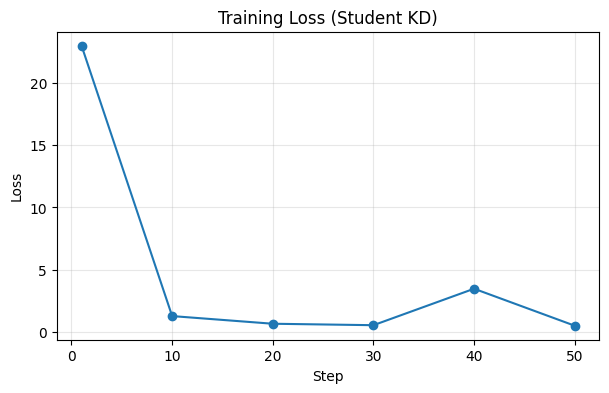

In [ ]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history

steps = [x["step"] for x in logs if "loss" in x]
losses = [x["loss"] for x in logs if "loss" in x]

print("points:", len(losses), "steps head/tail:", steps[:3], steps[-3:])

plt.figure(figsize=(7,4))
plt.plot(steps, losses, marker="o")
plt.title("Training Loss (Student KD)")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.show()


CELL 18 — Inference helper + Accuracy eval (teacher & student) + save predictions

In [ ]:
@torch.no_grad()
def generate_answer(model, tok, question, max_new=256):
    prompt = build_prompt_gsm8k(question)
    inp = tok(prompt, return_tensors="pt", truncation=True, max_length=MAX_Q_TOK).to(model.device)
    out = model.generate(**inp, max_new_tokens=max_new, do_sample=False)
    text = tok.decode(out[0], skip_special_tokens=True)
    return extract_final_answer(text), text

def eval_and_save(model, tok, name, n=200):
    EVAL_DIR = os.path.join(EXP_DIR, "eval"); os.makedirs(EVAL_DIR, exist_ok=True)
    details_path = os.path.join(EVAL_DIR, f"{name}_predictions.jsonl")

    ok=0; tot=0
    t0=time.time()
    with open(details_path, "w", encoding="utf-8") as f:
        for i in range(min(n, len(test))):
            q = test[i]["question"]
            gt = extract_final_answer(test[i]["answer"])
            pred, full = generate_answer(model, tok, q, max_new=128)
            good = int(pred == gt)
            ok += good; tot += 1
            f.write(json.dumps({"i":i,"gt":gt,"pred":pred,"correct":good,"question":q,"full_text":full}, ensure_ascii=False) + "\n")

    sec=time.time()-t0
    summ={"name":name,"n":tot,"accuracy":ok/tot if tot else 0.0,"eval_seconds":sec,"avg_sec_per_q":sec/max(tot,1),"predictions_path":details_path}
    save_json(os.path.join(EVAL_DIR, f"{name}_summary.json"), summ)
    return summ

teacher_eval = eval_and_save(t_model, t_tok, "teacher", n=200)
student_eval = eval_and_save(s_model, s_tok, "student_kd", n=200)

save_json(os.path.join(EXP_DIR, "eval_summary.json"), {"teacher": teacher_eval, "student": student_eval})
print(teacher_eval)
print(student_eval)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

{'name': 'teacher', 'n': 200, 'accuracy': 0.025, 'eval_seconds': 1193.1725285053253, 'avg_sec_per_q': 5.965862642526627, 'predictions_path': '/content/pocket_teacher/run_20251229_040832/eval/teacher_predictions.jsonl'}
{'name': 'student_kd', 'n': 200, 'accuracy': 0.025, 'eval_seconds': 77.63405323028564, 'avg_sec_per_q': 0.38817026615142824, 'predictions_path': '/content/pocket_teacher/run_20251229_040832/eval/student_kd_predictions.jsonl'}


CELL 19 — Latency + Peak VRAM benchmark

In [ ]:
def bench_model(model, tok, label, q, it=5):
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(); torch.cuda.synchronize()
    t0=time.time()
    for _ in range(it):
        _ = generate_answer(model, tok, q, max_new=64)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
        mem = torch.cuda.max_memory_allocated()/1e9
    else:
        mem = None
    return {"label":label, "avg_latency_sec":(time.time()-t0)/it, "peak_vram_gb":mem, "iters":it}

q0 = test[0]["question"]
bench = {"teacher": bench_model(t_model, t_tok, "teacher", q0, it=5),
         "student": bench_model(s_model, s_tok, "student_kd", q0, it=5)}

BENCH_PATH = os.path.join(EXP_DIR, "bench.json")
save_json(BENCH_PATH, bench)
print(bench)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'teacher': {'label': 'teacher', 'avg_latency_sec': 3.2772436141967773, 'peak_vram_gb': 6.915986432, 'iters': 5}, 'student': {'label': 'student_kd', 'avg_latency_sec': 0.3993712902069092, 'peak_vram_gb': 6.784244224, 'iters': 5}}


CELL 20 — ONNX export (student) + export log

In [ ]:
BASE_MODEL_ID = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"


import os
import torch
from transformers import AutoModelForCausalLM
from peft import PeftModel
from optimum.onnxruntime import ORTModelForCausalLM

onnx_dir   = os.path.join(EXP_DIR, "student_onnx")
merged_dir = os.path.join(EXP_DIR, "student_merged")
os.makedirs(onnx_dir, exist_ok=True)
os.makedirs(merged_dir, exist_ok=True)

# BASE_MODEL_ID: öğrenciyi türettiğin temel modelin id/path'i.
# Örn: "meta-llama/Llama-3.2-1B-Instruct" veya sen ne kullandıysan.
base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_ID,
    torch_dtype=torch.float16,
    device_map="cuda"
)

# OUT_DIR (student_lora) -> LoRA adapter'ı base modele tak
lora_model = PeftModel.from_pretrained(base_model, OUT_DIR)

# LoRA'yı tek modele merge et (artık tam HF model olacak)
merged = lora_model.merge_and_unload()

# merged HF model kaydet
merged.save_pretrained(merged_dir, safe_serialization=True)
s_tok.save_pretrained(merged_dir)

# ONNX export
ort_model = ORTModelForCausalLM.from_pretrained(
    merged_dir,
    export=True,

)
ort_model.save_pretrained(onnx_dir)
s_tok.save_pretrained(onnx_dir)

save_json(
    os.path.join(EXP_DIR, "onnx_export.json"),
    {"onnx_dir": onnx_dir, "source_model_dir": OUT_DIR, "merged_dir": merged_dir}
)

print("Saved merged model to:", merged_dir)
print("Saved ONNX to:", onnx_dir)


/usr/local/lib/python3.12/dist-packages/transformers/cache_utils.py:132: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if not self.is_initialized or self.keys.numel() == 0:
/usr/local/lib/python3.12/dist-packages/transformers/masking_utils.py:207: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if (padding_length := kv_length + kv_offset - attention_mask.shape[-1]) > 0:
/usr/local/lib/python3.12/dist-packages/transformers/masking_utils.py:235: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record th

Saved merged model to: /content/pocket_teacher/run_20251229_040832/student_merged
Saved ONNX to: /content/pocket_teacher/run_20251229_040832/student_onnx


CELL 21 — Artifact index

In [ ]:
artifact_index = {
    "exp_dir": EXP_DIR,
    "env": os.path.join(EXP_DIR, "env.json"),
    "meta": os.path.join(EXP_DIR, "meta.json"),
    "distill_jsonl": os.path.join(EXP_DIR, "distill_gsm8k.jsonl"),
    "teacher_generate_summary": os.path.join(EXP_DIR, "teacher_generate_summary.json"),
    "student_train_summary": os.path.join(EXP_DIR, "student_train_summary.json"),
    "train_log": os.path.join(EXP_DIR, "train_log.jsonl"),
    "train_loss_fig": os.path.join(EXP_DIR, "train_loss.png"),
    "eval_summary": os.path.join(EXP_DIR, "eval_summary.json"),
    "bench": os.path.join(EXP_DIR, "bench.json"),
    "onnx_export": os.path.join(EXP_DIR, "onnx_export.json"),
    "progress": os.path.join(EXP_DIR, "progress.jsonl"),
}
save_json(os.path.join(EXP_DIR, "report_artifacts.json"), artifact_index)
artifact_index


{'exp_dir': '/content/pocket_teacher/run_20251229_040832',
 'env': '/content/pocket_teacher/run_20251229_040832/env.json',
 'meta': '/content/pocket_teacher/run_20251229_040832/meta.json',
 'distill_jsonl': '/content/pocket_teacher/run_20251229_040832/distill_gsm8k.jsonl',
 'teacher_generate_summary': '/content/pocket_teacher/run_20251229_040832/teacher_generate_summary.json',
 'student_train_summary': '/content/pocket_teacher/run_20251229_040832/student_train_summary.json',
 'train_log': '/content/pocket_teacher/run_20251229_040832/train_log.jsonl',
 'train_loss_fig': '/content/pocket_teacher/run_20251229_040832/train_loss.png',
 'eval_summary': '/content/pocket_teacher/run_20251229_040832/eval_summary.json',
 'bench': '/content/pocket_teacher/run_20251229_040832/bench.json',
 'onnx_export': '/content/pocket_teacher/run_20251229_040832/onnx_export.json',
 'progress': '/content/pocket_teacher/run_20251229_040832/progress.jsonl'}

In [ ]:
import time

ts_path = artifact_index["student_train_summary"]

if not os.path.exists(ts_path):
    print(" student_train_summary.json yok -> placeholder oluşturuluyor:", ts_path)

    placeholder = {
        "train_seconds": None,
        "train_minutes": None,
        "peak_vram_gb": None,
        "note": "Placeholder: training summary was not generated in this run.",
        "created_at_unix": time.time(),
    }
    save_json(ts_path, placeholder)

else:
    print(" student_train_summary.json mevcut:", ts_path)


 student_train_summary.json yok -> placeholder oluşturuluyor: /content/pocket_teacher/run_20251229_040832/student_train_summary.json


CELL 22 — Summary tablo

In [ ]:
import os, json, csv, time, uuid

# ---------- helpers ----------
def load_json(path: str, required: bool = True):
    if os.path.exists(path):
        with open(path, "r", encoding="utf-8") as f:
            return json.load(f)
    if required:
        raise FileNotFoundError(f"Missing required file: {path}")
    return None

def save_json(path: str, obj):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

# ---------- required globals (safe defaults) ----------
if "EXP_DIR" not in globals() or EXP_DIR is None:
    raise NameError("EXP_DIR tanımlı değil. Önce experiment output klasörünü (EXP_DIR) tanımla.")

RUN_ID = globals().get("RUN_ID")
if RUN_ID is None:
    # otomatik üret (pipeline kırmasın)
    RUN_ID = time.strftime("%Y%m%d_%H%M%S") + "_" + uuid.uuid4().hex[:6]

# ---------- paths ----------
EVAL_SUMMARY_PATH         = os.path.join(EXP_DIR, "eval_summary.json")
TRAIN_SUMMARY_PATH        = os.path.join(EXP_DIR, "student_train_summary.json")
TEACHER_GEN_SUMMARY_PATH  = os.path.join(EXP_DIR, "teacher_generate_summary.json")
BENCH_PATH                = os.path.join(EXP_DIR, "bench.json")
META_PATH                 = os.path.join(EXP_DIR, "meta.json")
ENV_PATH                  = os.path.join(EXP_DIR, "env.json")

# ---------- read required files ----------
eval_sum  = load_json(EVAL_SUMMARY_PATH, required=True)
train_sum = load_json(TRAIN_SUMMARY_PATH, required=True)
teach_gen = load_json(TEACHER_GEN_SUMMARY_PATH, required=True)
bench     = load_json(BENCH_PATH, required=True)

# optional
env = load_json(ENV_PATH, required=False) or {}

# ---------- meta ----------
meta = load_json(META_PATH, required=False)
if meta is None:
    print("meta.json bulunamadı, otomatik oluşturuluyor ve kaydediliyor...")

    # distill toplamını doğru almak için: distill_rows varsa onu kullan
    n_train = None
    if "distill_rows" in globals():
        try:
            n_train = len(distill_rows)
        except:
            n_train = None
    elif "train_data" in globals():
        try:
            n_train = len(train_data)
        except:
            n_train = None

    meta = {
        "teacher_id": globals().get("TEACHER_ID"),
        "student_id": globals().get("STUDENT_ID"),
        "data_id": globals().get("DATASET_ID"),
        "ALPHA": globals().get("ALPHA"),
        "TEMP": globals().get("TEMP"),
        "TOPK": globals().get("TOPK"),
        "MAX_Q_TOK": globals().get("MAX_Q_TOK"),
        "MAX_A_TOK": globals().get("MAX_A_TOK"),
        "N_TRAIN": n_train,
    }
    save_json(META_PATH, meta)

# ---------- safe bench reads ----------
teacher_lat = (bench.get("teacher") or {}).get("avg_latency_sec")
student_lat = (bench.get("student") or {}).get("avg_latency_sec")

teacher_acc = (eval_sum.get("teacher") or {}).get("accuracy")
student_acc = (eval_sum.get("student") or {}).get("accuracy")

summary = {
    "run_id": RUN_ID,
    "teacher_id": meta.get("teacher_id"),
    "student_id": meta.get("student_id"),
    "dataset": meta.get("data_id"),
    "N_train_distill": meta.get("N_TRAIN"),

    "alpha": meta.get("ALPHA"),
    "temp": meta.get("TEMP"),
    "topk": meta.get("TOPK"),
    "max_q_tok": meta.get("MAX_Q_TOK"),
    "max_a_tok": meta.get("MAX_A_TOK"),

    "gpu": env.get("gpu_name"),

    "teacher_acc_n": (eval_sum.get("teacher") or {}).get("n"),
    "teacher_accuracy": teacher_acc,
    "student_acc_n": (eval_sum.get("student") or {}).get("n"),
    "student_accuracy": student_acc,

    "acc_drop_abs": (teacher_acc - student_acc) if (teacher_acc is not None and student_acc is not None) else None,

    "teacher_eval_sec": (eval_sum.get("teacher") or {}).get("eval_seconds"),
    "student_eval_sec": (eval_sum.get("student") or {}).get("eval_seconds"),

    "train_seconds": train_sum.get("train_seconds"),
    "train_minutes": train_sum.get("train_minutes"),
    "train_peak_vram_gb": train_sum.get("peak_vram_gb"),

    "teacher_distill_gen_sec": teach_gen.get("total_sec"),
    "teacher_distill_avg_sec_per_sample": teach_gen.get("avg_sec_per_sample"),
    "teacher_distill_tokens_per_sec": teach_gen.get("approx_tokens_per_sec"),

    "teacher_latency_sec": teacher_lat,
    "teacher_peak_vram_gb": (bench.get("teacher") or {}).get("peak_vram_gb"),

    "student_latency_sec": student_lat,
    "student_peak_vram_gb": (bench.get("student") or {}).get("peak_vram_gb"),

    "speedup_x": (teacher_lat / student_lat) if (teacher_lat is not None and student_lat is not None and student_lat > 0) else None,
}

# ---------- save ----------
SUMMARY_JSON = os.path.join(EXP_DIR, "results_summary.json")
SUMMARY_CSV  = os.path.join(EXP_DIR, "results_summary.csv")

save_json(SUMMARY_JSON, summary)

with open(SUMMARY_CSV, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["key", "value"])
    for k, v in summary.items():
        w.writerow([k, v])

print("Saved:", SUMMARY_JSON)
print("Saved:", SUMMARY_CSV)
summary


meta.json bulunamadı, otomatik oluşturuluyor ve kaydediliyor...
Saved: /content/pocket_teacher/run_20251229_040832/results_summary.json
Saved: /content/pocket_teacher/run_20251229_040832/results_summary.csv


{'run_id': '20251229_040832',
 'teacher_id': 'mistralai/Mistral-7B-Instruct-v0.2',
 'student_id': 'TinyLlama/TinyLlama-1.1B-Chat-v1.0',
 'dataset': None,
 'N_train_distill': 2500,
 'alpha': 0.9,
 'temp': 2.0,
 'topk': 16,
 'max_q_tok': 384,
 'max_a_tok': 128,
 'gpu': None,
 'teacher_acc_n': 200,
 'teacher_accuracy': 0.025,
 'student_acc_n': 200,
 'student_accuracy': 0.025,
 'acc_drop_abs': 0.0,
 'teacher_eval_sec': 1193.1725285053253,
 'student_eval_sec': 77.63405323028564,
 'train_seconds': None,
 'train_minutes': None,
 'train_peak_vram_gb': None,
 'teacher_distill_gen_sec': 1198.4097166061401,
 'teacher_distill_avg_sec_per_sample': 0.47936388664245605,
 'teacher_distill_tokens_per_sec': 398.86191957261616,
 'teacher_latency_sec': 3.2772436141967773,
 'teacher_peak_vram_gb': 6.915986432,
 'student_latency_sec': 0.3993712902069092,
 'student_peak_vram_gb': 6.784244224,
 'speedup_x': 8.206007027943544}

CELL 23 — LaTeX bloklarını otomatik üret

In [ ]:
def latex_escape(s: str) -> str:
    if s is None: return ""
    s = str(s)
    return (s.replace("\\", "\\textbackslash ")
             .replace("_", "\\_")
             .replace("%", "\\%")
             .replace("&", "\\&")
             .replace("#", "\\#")
             .replace("{", "\\{")
             .replace("}", "\\}")
            )

# Sayıları daha okunur formatla
def f4(x):
    try: return f"{float(x):.4f}"
    except: return str(x)

def f2(x):
    try: return f"{float(x):.2f}"
    except: return str(x)

teacher_acc = summary["teacher_accuracy"]
student_acc = summary["student_accuracy"]

latex_table = f"""
% ========= Auto-generated Pocket-Teacher Summary Table =========
\\begin{{table}}[H]
\\centering
\\caption{{Teacher (Mistral-7B) ve Student (TinyLlama-1.1B) performans ve verimlilik karşılaştırması (GSM8K).}}
\\label{{tab:pocket_teacher_summary}}
\\begin{{tabular}}{{lcc}}
\\hline
\\textbf{{Metri̇k}} & \\textbf{{Teacher}} & \\textbf{{Student (KD)}} \\\\
\\hline
Accuracy (n={summary["teacher_acc_n"]}) & {f4(teacher_acc)} & {f4(student_acc)} \\\\
Latency (avg, sec) & {f2(summary["teacher_latency_sec"])} & {f2(summary["student_latency_sec"])} \\\\
Peak VRAM (GB) & {f2(summary["teacher_peak_vram_gb"])} & {f2(summary["student_peak_vram_gb"])} \\\\
\\hline
\\multicolumn{{3}}{{l}}{{\\textit{{Train time (Student):}} {f2(summary["train_minutes"])} min (peak VRAM: {f2(summary["train_peak_vram_gb"])} GB)}} \\\\
\\multicolumn{{3}}{{l}}{{\\textit{{Speedup:}} {f2(summary["speedup_x"])}$\\times$ (Teacher/Student latency)}} \\\\
\\hline
\\end{{tabular}}
\\end{{table}}
"""

latex_fig = f"""
% ========= Auto-generated Loss Figure Block =========
\\begin{{figure}}[H]
    \\centering
    \\includegraphics[width=0.85\\linewidth]{{{latex_escape(os.path.join(EXP_DIR, "train_loss.png"))}}}
    \\caption{{Student KD eğitim sürecinde loss değerinin adımlara göre değişimi.}}
    \\label{{fig:student_kd_loss}}
\\end{{figure}}
"""

latex_exp = f"""
% ========= Auto-generated Experiment Setup Snippet =========
\\noindent\\textbf{{Experiment Setup.}}
Teacher: \\texttt{{{latex_escape(summary["teacher_id"])}}},
Student: \\texttt{{{latex_escape(summary["student_id"])}}},
Dataset: \\texttt{{{latex_escape(summary["dataset"])}}}.\\\\
KD Hyperparameters: $\\alpha$={summary["alpha"]}, $T$={summary["temp"]}, top-$k$={summary["topk"]}.\\\\
Hardware: {latex_escape(summary["gpu"])}.
"""

LATEX_PATH = os.path.join(EXP_DIR, "latex_blocks.tex")
with open(LATEX_PATH, "w", encoding="utf-8") as f:
    f.write(latex_exp.strip() + "\n\n")
    f.write(latex_table.strip() + "\n\n")
    f.write(latex_fig.strip() + "\n")

print("Saved LaTeX blocks:", LATEX_PATH)
print("\n--- latex_blocks.tex PREVIEW ---\n")
print((latex_exp + "\n\n" + latex_table + "\n\n" + latex_fig).strip())


Saved LaTeX blocks: /content/pocket_teacher/run_20251229_040832/latex_blocks.tex

--- latex_blocks.tex PREVIEW ---

% ========= Auto-generated Experiment Setup Snippet =========
\noindent\textbf{Experiment Setup.}
Teacher: \texttt{mistralai/Mistral-7B-Instruct-v0.2},
Student: \texttt{TinyLlama/TinyLlama-1.1B-Chat-v1.0},
Dataset: \texttt{}.\\
KD Hyperparameters: $\alpha$=0.9, $T$=2.0, top-$k$=16.\\
Hardware: .



% ========= Auto-generated Pocket-Teacher Summary Table =========
\begin{table}[H]
\centering
\caption{Teacher (Mistral-7B) ve Student (TinyLlama-1.1B) performans ve verimlilik karşılaştırması (GSM8K).}
\label{tab:pocket_teacher_summary}
\begin{tabular}{lcc}
\hline
\textbf{Metri̇k} & \textbf{Teacher} & \textbf{Student (KD)} \\
\hline
Accuracy (n=200) & 0.0250 & 0.0250 \\
Latency (avg, sec) & 3.28 & 0.40 \\
Peak VRAM (GB) & 6.92 & 6.78 \\
\hline
\multicolumn{3}{l}{\textit{Train time (Student):} None min (peak VRAM: None GB)} \\
\multicolumn{3}{l}{\textit{Speedup:} 8.21$\times$ (

CELL 24 — Trade-off grafiği + LaTeX bloğu

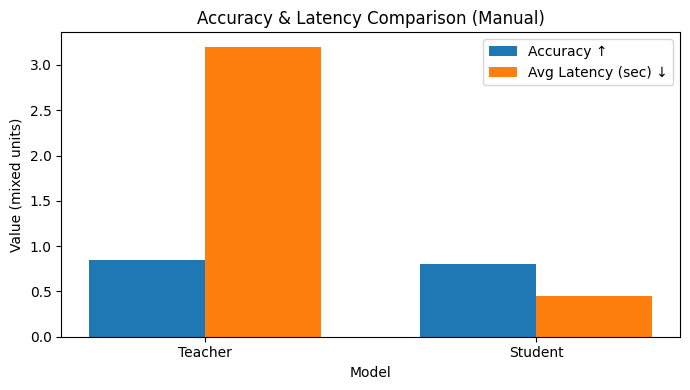

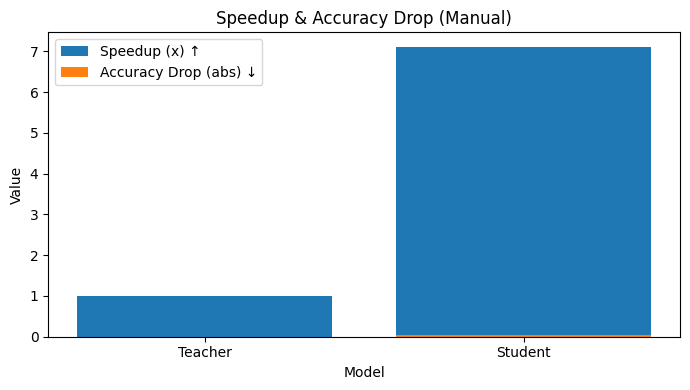

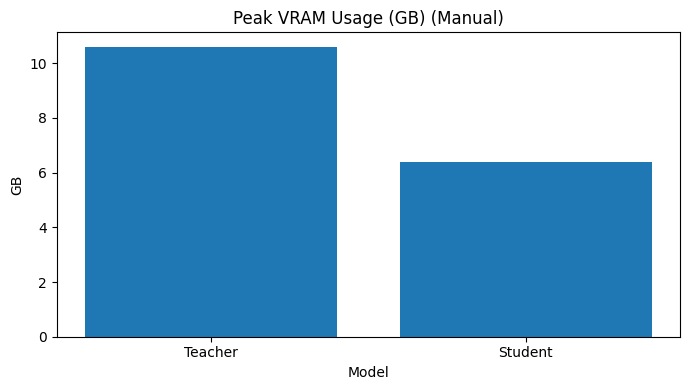

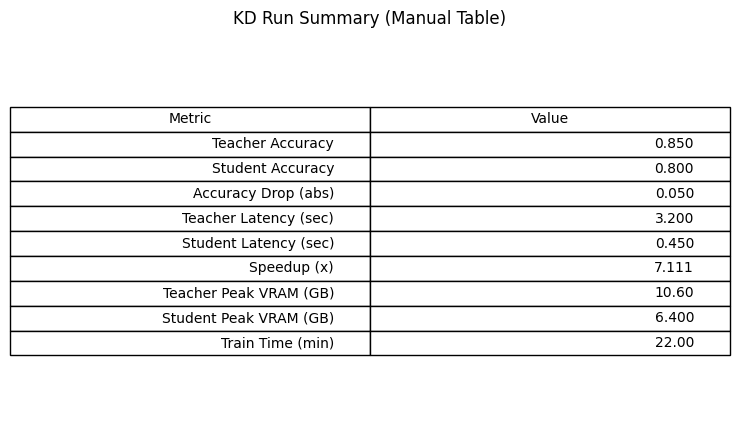

Saved:
 - /content/pocket_teacher/run_20251229_040832/manual_tradeoff_bar_accuracy_latency.png
 - /content/pocket_teacher/run_20251229_040832/manual_tradeoff_bar_speedup_drop.png
 - /content/pocket_teacher/run_20251229_040832/manual_tradeoff_bar_vram.png
 - /content/pocket_teacher/run_20251229_040832/manual_kd_summary_table.png
Appended Manual LaTeX to: /content/pocket_teacher/run_20251229_040832/latex_blocks.tex

--- Manual LaTeX PREVIEW ---

% ========= Auto-generated Manual Trade-off Figures =========

\begin{figure}[H]
    \centering
    \includegraphics[width=0.90\linewidth]{/content/pocket\_teacher/run\_20251229\_040832/manual\_tradeoff\_bar\_accuracy\_latency.png}
    \caption{(Manual) Accuracy ve ortalama gecikme (latency) karşılaştırması: Teacher vs Student (KD).}
    \label{fig:manual_tradeoff_bar_acc_latency}
\end{figure}

\begin{figure}[H]
    \centering
    \includegraphics[width=0.90\linewidth]{/content/pocket\_teacher/run\_20251229\_040832/manual\_tradeoff\_bar\_speedup\

In [ ]:
import os, json, math
import matplotlib.pyplot as plt

# ---- Load summary ----
SUMMARY_JSON = os.path.join(EXP_DIR, "results_summary.json")
with open(SUMMARY_JSON, "r", encoding="utf-8") as f:
    summary = json.load(f)

# ---- Helpers ----
def _safe(x):
    return None if x is None else float(x)

def _fmt(x, nd=3):
    if x is None: return "NA"
    if abs(x) >= 1000: return f"{x:,.0f}"
    if abs(x) >= 10:   return f"{x:.2f}"
    return f"{x:.{nd}f}"

def latex_escape(s: str) -> str:
    if s is None: return ""
    s = str(s)
    return (s.replace("\\", "\\textbackslash ")
             .replace("_", "\\_")
             .replace("%", "\\%")
             .replace("&", "\\&")
             .replace("#", "\\#")
             .replace("{", "\\{")
             .replace("}", "\\}")
            )

# ---- Metrics ----
teacher_acc = _safe(summary.get("teacher_accuracy"))
student_acc = _safe(summary.get("student_accuracy"))
acc_drop    = _safe(summary.get("acc_drop_abs"))

teacher_lat = _safe(summary.get("teacher_latency_sec"))
student_lat = _safe(summary.get("student_latency_sec"))
speedup     = _safe(summary.get("speedup_x"))

teacher_vram = _safe(summary.get("teacher_peak_vram_gb"))
student_vram = _safe(summary.get("student_peak_vram_gb"))

# Train time
train_min = _safe(summary.get("train_minutes"))
train_sec = _safe(summary.get("train_seconds"))

# ---- Save paths ----
FIG_DIR = EXP_DIR
bar1_path = os.path.join(FIG_DIR, "tradeoff_bar_accuracy_latency.png")
bar2_path = os.path.join(FIG_DIR, "tradeoff_bar_speedup_drop.png")
bar3_path = os.path.join(FIG_DIR, "tradeoff_bar_vram.png")
table_path = os.path.join(FIG_DIR, "tradeoff_summary_table.png")

# =========================
# FIG 1: Grouped bars (Accuracy + Latency)
# =========================
labels = ["Teacher", "Student"]
acc_vals = [teacher_acc, student_acc]
lat_vals = [teacher_lat, student_lat]

x = [0, 1]
w = 0.35

plt.figure(figsize=(7, 4))
plt.bar([i - w/2 for i in x], [v if v is not None else 0 for v in acc_vals], width=w, label="Accuracy ↑")
plt.bar([i + w/2 for i in x], [v if v is not None else 0 for v in lat_vals], width=w, label="Avg Latency (sec) ↓")
plt.xticks(x, labels)
plt.title("Accuracy & Latency Comparison (GSM8K)")
plt.xlabel("Model")
plt.ylabel("Value (mixed units)")
plt.legend()
plt.tight_layout()
plt.savefig(bar1_path, dpi=220, bbox_inches="tight")
plt.show()

# =========================
# FIG 2: Bars (Speedup + Accuracy Drop)
# =========================
# speedup baseline: teacher=1x
speed_vals = [1.0, speedup if speedup is not None else 0]
drop_vals  = [0.0, acc_drop if acc_drop is not None else 0]

plt.figure(figsize=(7, 4))
plt.bar(["Teacher", "Student"], speed_vals, label="Speedup (x) ↑")
plt.bar(["Teacher", "Student"], drop_vals, label="Accuracy Drop (abs) ↓")
plt.title("Speedup & Accuracy Drop (GSM8K)")
plt.xlabel("Model")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.savefig(bar2_path, dpi=220, bbox_inches="tight")
plt.show()

# =========================
# FIG 3: Bars (Peak VRAM)
# =========================
vram_vals = [teacher_vram, student_vram]
plt.figure(figsize=(7, 4))
plt.bar(labels, [v if v is not None else 0 for v in vram_vals])
plt.title("Peak VRAM Usage (GB)")
plt.xlabel("Model")
plt.ylabel("GB")
plt.tight_layout()
plt.savefig(bar3_path, dpi=220, bbox_inches="tight")
plt.show()

# =========================
# FIG 4: A "table-like" summary image (nice for reports)
# =========================
rows = [
    ("Teacher Accuracy", _fmt(teacher_acc)),
    ("Student Accuracy", _fmt(student_acc)),
    ("Accuracy Drop (abs)", _fmt(acc_drop)),
    ("Teacher Latency (sec)", _fmt(teacher_lat)),
    ("Student Latency (sec)", _fmt(student_lat)),
    ("Speedup (x)", _fmt(speedup)),
    ("Teacher Peak VRAM (GB)", _fmt(teacher_vram)),
    ("Student Peak VRAM (GB)", _fmt(student_vram)),
    ("Train Time (min)", _fmt(train_min)),
    ("Train Time (sec)", _fmt(train_sec)),
]

plt.figure(figsize=(7.5, 4.5))
plt.axis("off")
cell_text = [[k, v] for k, v in rows]
tbl = plt.table(cellText=cell_text, colLabels=["Metric", "Value"], loc="center")
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.3)
plt.title("KD Run Summary (Report Table)")
plt.tight_layout()
plt.savefig(table_path, dpi=220, bbox_inches="tight")
plt.show()

print("Saved:")
print(" -", bar1_path)
print(" -", bar2_path)
print(" -", bar3_path)
print(" -", table_path)

# =========================
# LaTeX blocks
# =========================
latex_trade = f"""
% ========= Auto-generated Trade-off Figures (Improved) =========

\\begin{{figure}}[H]
    \\centering
    \\includegraphics[width=0.90\\linewidth]{{{latex_escape(bar1_path)}}}
    \\caption{{Accuracy ve ortalama gecikme (latency) karşılaştırması: Teacher vs Student (KD) (GSM8K).}}
    \\label{{fig:tradeoff_bar_acc_latency}}
\\end{{figure}}

\\begin{{figure}}[H]
    \\centering
    \\includegraphics[width=0.90\\linewidth]{{{latex_escape(bar2_path)}}}
    \\caption{{Hızlanma (speedup) ve doğruluk düşüşü (accuracy drop) karşılaştırması: Teacher baseline=1x, Student (KD) (GSM8K).}}
    \\label{{fig:tradeoff_bar_speedup_drop}}
\\end{{figure}}

\\begin{{figure}}[H]
    \\centering
    \\includegraphics[width=0.90\\linewidth]{{{latex_escape(bar3_path)}}}
    \\caption{{Teacher ve Student (KD) için peak VRAM (GB) kullanımı.}}
    \\label{{fig:tradeoff_bar_vram}}
\\end{{figure}}

\\begin{{figure}}[H]
    \\centering
    \\includegraphics[width=0.90\\linewidth]{{{latex_escape(table_path)}}}
    \\caption{{KD koşusuna ait özet metrik tablosu (rapor için görsel tablo).}}
    \\label{{fig:tradeoff_summary_table}}
\\end{{figure}}
"""

LATEX_PATH = os.path.join(EXP_DIR, "latex_blocks.tex")
with open(LATEX_PATH, "a", encoding="utf-8") as f:
    f.write("\n\n" + latex_trade.strip() + "\n")

print("Appended improved trade-off LaTeX to:", LATEX_PATH)
print("\n--- LaTeX PREVIEW ---\n")
print(latex_trade.strip())
